Прежде чем запускать следующее, нужно пройти VK-авторизацию!

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from collections import defaultdict
from matplotlib import pyplot as plt
from urllib import urlencode

import urllib2
import time
import json
import operator
import urllib2 

In [2]:
file = open('datasets/token', 'r')
accessToken = file.read()

# Достаем участников групп

In [288]:
groups = ["109490789", 
          "2100831", 
          "11912933", 
          "1167943", 
          "15335079", 
          "12813079", 
          "68478644",
          "16vzvoduvo",
          "59565067",
          "61511779",
          "1182973",
          "1119648",
          "21754234",
          "14294712",
          "7591998",
          "8702762",
          "23386497",
          "1566321",
          "55523638"]

users = []

for group in groups:
    params = {"group_id": group, 
              "count": 500, 
              "fields": "sex,education,universities,schools",
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.getMembers?" + params
    data = json.load(urllib2.urlopen(url))
    data_users = data['response']['users']
    
    print("extracted %d users from %s" % (len(data_users), group))
    users.extend(data_users)
    time.sleep(0.5)
    
print("sum: %d" % len(users))

f = open('datasets/policeGroups/users.json','w')
f.write(json.dumps(users))
f.close()

extracted 26 users from 109490789
extracted 326 users from 2100831
extracted 51 users from 11912933
extracted 104 users from 1167943
extracted 41 users from 15335079
extracted 31 users from 12813079
extracted 17 users from 68478644
extracted 13 users from 16vzvoduvo
extracted 97 users from 59565067
extracted 30 users from 61511779
extracted 341 users from 1182973
extracted 233 users from 1119648
extracted 91 users from 21754234
extracted 8 users from 14294712
extracted 35 users from 7591998
extracted 34 users from 8702762
extracted 2 users from 23386497
extracted 86 users from 1566321
extracted 44 users from 55523638
sum: 1610


# Университеты полицейских

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


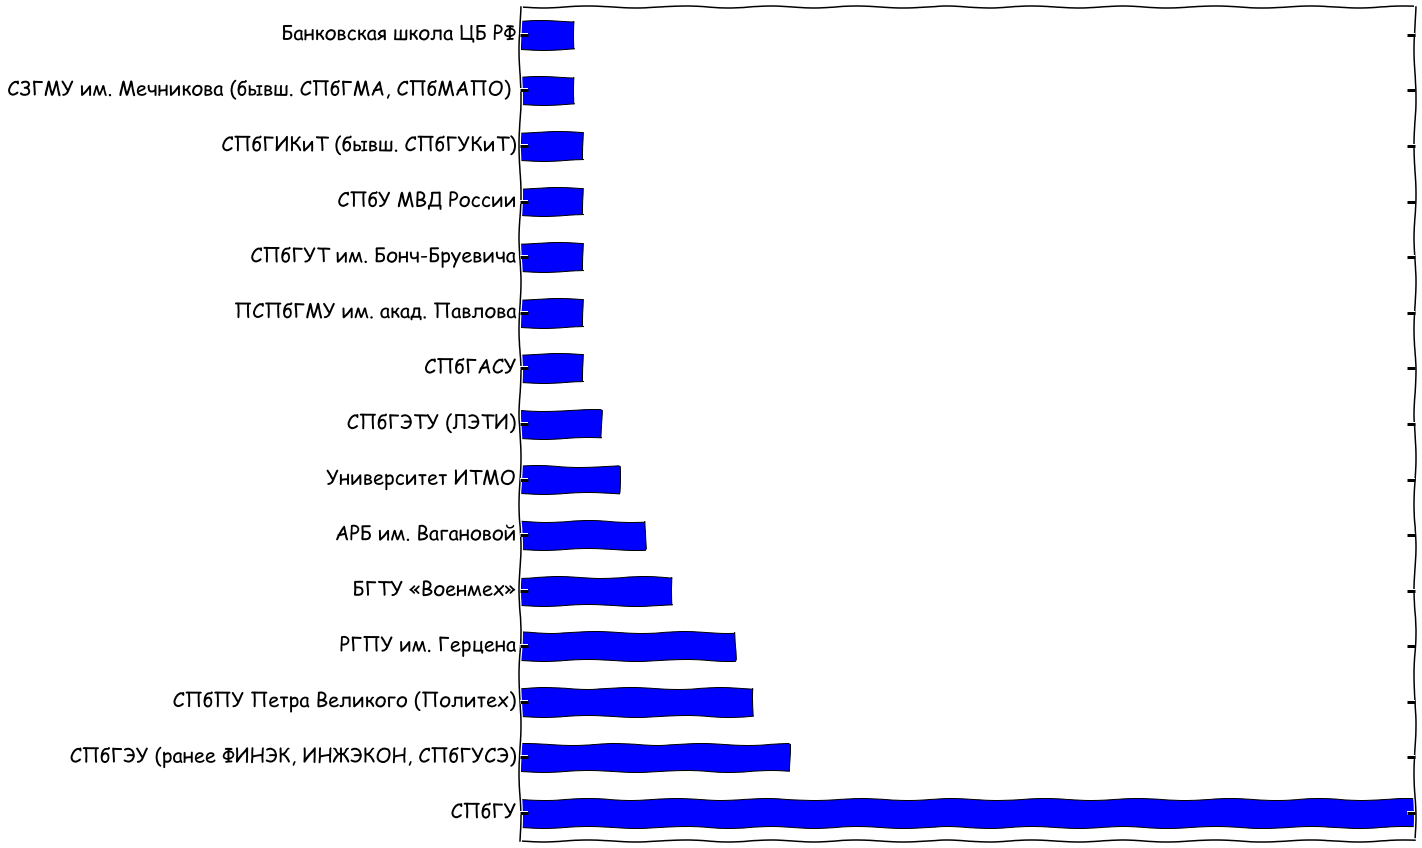

In [45]:
%matplotlib inline

with open('datasets/randomPeople/users.json') as data_file:    
    users = json.load(data_file)

df = pd.DataFrame(users)
df = df.groupby('university_name').size()

df.sort(['university_name'], ascending=False)
df = df.drop(df.index[[0]])
plt.figure(figsize=(15, 20))
plt.xkcd()

matplotlib.rc('xtick', labelsize=0)
matplotlib.rc('ytick', labelsize=20)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

p = df[:15].plot(kind='barh')
p.set_xlabel("")
p.set_ylabel("")
p.get_figure().set_size_inches(20, 12)
p.get_figure().tight_layout()
p.get_figure().savefig('images/universities_non_police_all.png', dpi=100)

# Пол полицейских

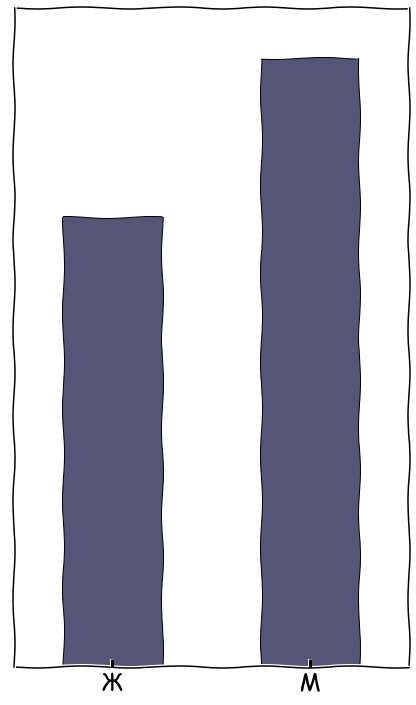

In [63]:
%matplotlib inline

with open('datasets/policeGroups/users.json') as data_file:    
    users = json.load(data_file)

def update_sex(user):
    user['sex_name'] = {
        0: 'N/A',
        1: u'Ж',
        2: u'М',
    }[user['sex']]
    return user

users = map(update_sex, users)
users = filter(lambda x: x['sex'] != 0, users)
    
df = pd.DataFrame(users)
df = df.groupby('sex_name').size()

p = df.plot(kind='bar', color='#555577')

plt.xkcd()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',
    bottom='on')         # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',
    right='off')         # labels along the bottom edge are off

matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=0)

plt.xticks(rotation=0)

p.set_xlabel("")
p.get_figure().set_size_inches(6, 10)
p.get_figure().tight_layout()
p.get_figure().savefig('images/sex_police.png', dpi=100)

# Группы полицейских
Загружаем и кладем в файл

In [276]:
with open('datasets/policeGroups/users.json') as data_file:    
    users = json.load(data_file)

groups = {}

print("processing %d users" % len(users))
for i in range(0, len(users)):
    params = {"user_id": users[i]['uid'], 
              "extended": 0, 
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.get?" + params
    data = json.load(urllib2.urlopen(url))
    
    if data.get('response', ''):
        user_groups = data['response']
        for user_group in user_groups:
            groups[user_group] = groups.get(user_group, 0) + 1

        print "%d" % (i + 1),
    time.sleep(0.5)
    
f = open('datasets/policeGroups/groups_ids.json','w')
f.write(json.dumps(groups))
f.close()

processing 1610 users
1 2 3 4 5 6

KeyboardInterrupt: 

### Достанем названия каждой из групп из API и сохраняем все в файл

In [278]:
with open('datasets/policeGroups/groups_ids.json') as data_file:    
    groups = json.load(data_file)
    
sorted_groups = sorted(groups.items(), key=operator.itemgetter(1))
sorted_groups.reverse()

# ids of first 100 groups as string
group_ids = ",".join(map(lambda x: x[0], sorted_groups[:100]))
params = {"group_ids": group_ids}
params = urlencode(params)
url = "https://api.vk.com/method/groups.getById?" + params
data = json.load(urllib2.urlopen(url))

# function to "attach" people count to groups
def add_people_count(group_info):
    group_info['people_count'] = groups.get(str(group_info['gid']), 0)
    return group_info

if data.get('response', ''):
    groups_info = data['response']
    groups_info = map(add_people_count, groups_info)
    
    f = open('datasets/policeGroups/groups.json','w')
    f.write(json.dumps(groups_info))
    f.close()

### Загрузка полного датасета из файла и построение графика

In [26]:
with open('datasets/policeGroups/groups.json') as data_file:    
    groups_info = json.load(data_file)

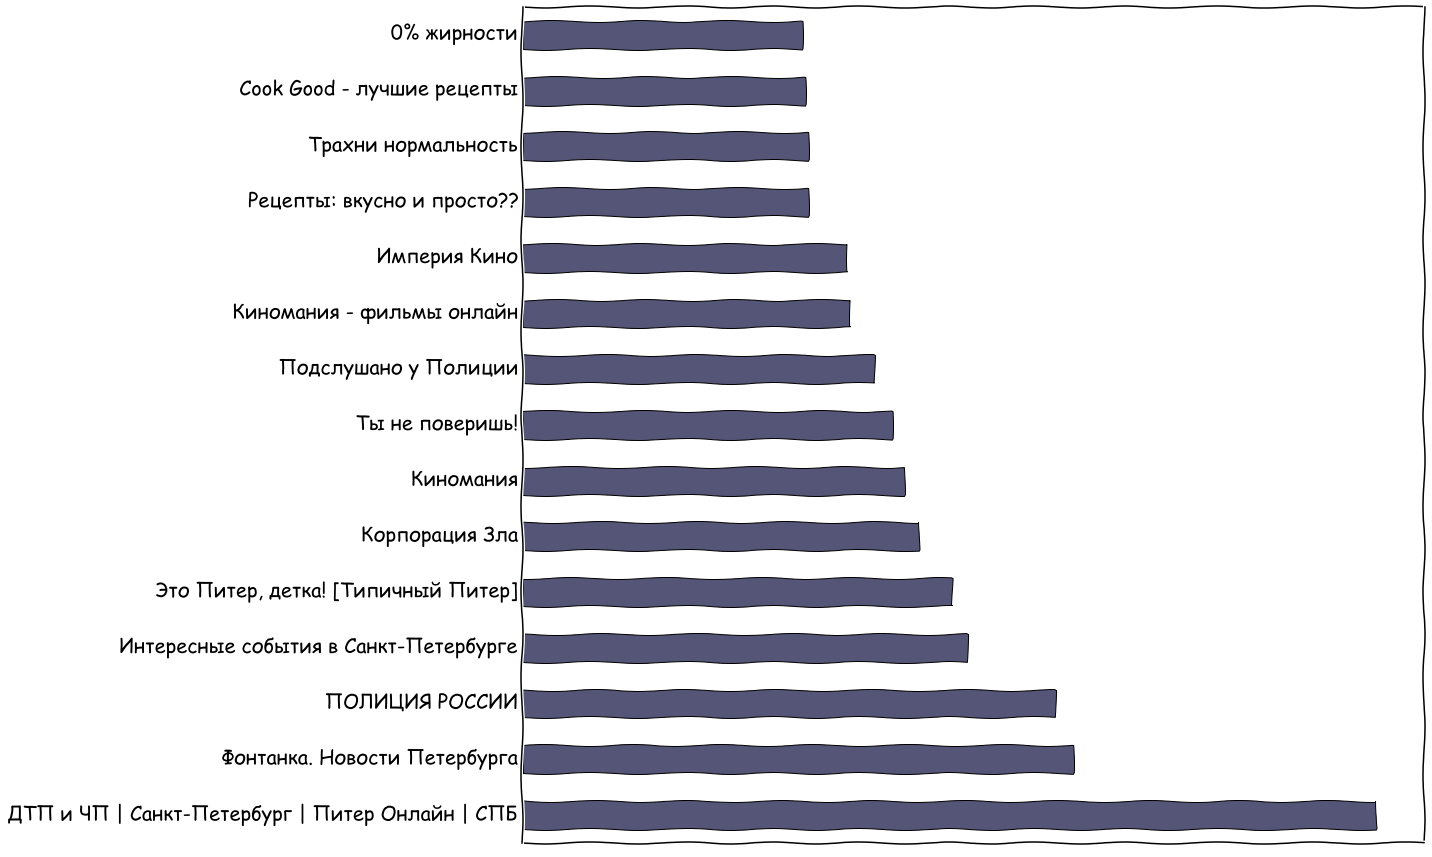

In [61]:
%matplotlib inline

def process_group_info(i):
    return {"name": i.get('name', ''),
            "count": i.get('people_count', 0)}

df = pd.DataFrame(map(process_group_info, groups_info[:15])).set_index('name')

matplotlib.rc('xtick', labelsize=0)
matplotlib.rc('ytick', labelsize=20)

p = df.plot(kind='barh', legend=False, color='#555577')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    top='off',
    bottom='off')         # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',
    right='off')         # labels along the bottom edge are off

p.set_ylabel("")
p.set_xlabel("")

p.get_figure().set_size_inches(20, 12)
p.get_figure().tight_layout()
p.get_figure().savefig('images/interests_police.png', dpi=100)